# 2. Preprocessing (전처리)

데이터를 머신러닝 모델에 피팅시키기 이전에 전처리가 필요하다.

스케일링을 통해 변수간 영향력이 동일하게끔 만들어줘야 하며,
- 스케일링과 관계없는 모델도 많긴 하지만, 필요한 경우도 있으므로 그냥 해준다 (클러스터링으로 새로운 변수를 만드는 경우...등등)

범주형/서열 변수의 경우 컴퓨터가 이해할 수 있도록 숫자로 바꿔주고, 원핫인코딩 등의 전처리 과정을 거쳐야한다.

변수 하나하나의 속성을 파악하며 신중하게 이루어져야하는 작업이지만, 이번 실습에서는 대략적인 흐름을 파악하고 간략하게나마 전처리를 진행해보자

실제 분석 상황이라면 EDA에서 얻은 정보를 바탕으로 더욱 자세하게 살펴보도록 하자

**`0.문제정의`** 에서 저장한 파일을 불러와서 전처리를 해보자

-- `Train`과 `Test`에 똑같이 적용해야한다

-------------
# Wage prediction

현대축구에서는 우수한 측면수비수를 보유한 팀이 세계를 지배한다. 

피파 게임 데이터를 이용하여 누가 과연 좋은 측면수비수일지 예측해보자.  

물론 평가기준은... **돈(Wage)**이다!!  
**(프로는 돈으로 말한다)**

- Target : `Wage`
- Metric : `mse`
- Player : only.. 측면수비.. `RB`, `RWB`, `LB`, `LWB`
- Dataset: `FIFA 19`
- Remark : 상위 1000명의 선수를 `train:test=7:3`의 비율로 나누어 실습

----------------------
# 모듈

In [1]:
import os
import sys
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import re
from time import sleep

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#그래프 폰트 전역 설정
plt.style.use('seaborn')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'calibri'
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize']   = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['xtick.labelsize'] = 16


from scipy import stats

import sklearn

------------------
# 데이터 불러오기

In [2]:
# 디렉토리 내 파일 확인
os.listdir()

['.git',
 '.ipynb_checkpoints',
 '0. 문제 정의.ipynb',
 '1. EDA.ipynb',
 '2. Preprocessing.ipynb',
 'Cross Validation.ipynb',
 'EDA - 복사본.ipynb',
 'fifa19.csv',
 'fifa_wage_prediction.xlsx',
 'Kmeans 연습.ipynb',
 'LICENSE',
 'Linear Regression.ipynb',
 'Log transformation.ipynb',
 'PCA 실전.ipynb',
 'PCA 연습.ipynb',
 'players_20.csv',
 'README.md',
 'SVM.ipynb',
 'test_prep.csv',
 'train_prep.csv',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'Untitled2.ipynb',
 '나만의 EDA_FIFA.ipynb',
 '코사인 유사도 연습.ipynb',
 '피파 머신러닝 연습(EDA).ipynb',
 '피파 머신러닝 흐름잡기.ipynb',
 '피파 머신러닝.zip']

In [3]:
fifa = pd.read_excel('fifa_wage_prediction.xlsx')
fifa.head(2)

Wage Value        Name  Age Nationality  Overall          Club  \
0   285  €43M     Marcelo   30      Brazil       88   Real Madrid   
1   250  €38M  Jordi Alba   29       Spain       87  FC Barcelona   

  Preferred Foot  International Reputation  Weak Foot  ...  Interceptions  \
0           Left                         4          4  ...             85   
1           Left                         3          3  ...             84   

  Positioning Vision Penalties Composure  Marking StandingTackle  \
0          85     82        59        86       71             85   
1          79     70        59        79       72             84   

  SlidingTackle feet  inch  
0            86    5     9  
1            85    5     7  

[2 rows x 52 columns]

-----------------
# X_train, X_test / y_train, y_test 분리

- Overall 능력치 순 상위 1000명의 data를 7:3 비율로 `train set`과 `test set`으로 분리

- `random_state=1`로 고정하여 `shuffle`

- `train set`을 이용하여 모델을 만들어보고, `test set`은 최종결과를 확인할 때만 사용

In [4]:
from sklearn.model_selection import train_test_split

# 능력치 순 상위 n명만 분리
n = 1000

X   = fifa.loc[:n,['Name', 'Age','Nationality','Overall', 'Club',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From',
       'Height', 'Weight',
       'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']]

# Wage 전처리 (숫자로 변환)
y = fifa.loc[:n,['Wage']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,shuffle=True)

`train`과 `test`를 똑같이 변형해줘야하기 때문에 list로 묶어 한번에 처리하자

In [5]:
tnt = [X_train, X_test]

------------------------
# 전처리

In [6]:
# 수치형변수 스케일링
# 범주형 변수 처리
# 이왕이면 범주형 변수도 같은 범위 안에 있도록 해주기

In [7]:
# Dtype 확인 (수치형 or 범주형)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 432 to 37
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      700 non-null    object 
 1   Age                       700 non-null    int64  
 2   Nationality               700 non-null    object 
 3   Overall                   700 non-null    int64  
 4   Club                      688 non-null    object 
 5   Preferred Foot            700 non-null    object 
 6   International Reputation  700 non-null    int64  
 7   Weak Foot                 700 non-null    int64  
 8   Skill Moves               700 non-null    int64  
 9   Work Rate                 700 non-null    object 
 10  Body Type                 700 non-null    object 
 11  Real Face                 700 non-null    object 
 12  Position                  700 non-null    object 
 13  Jersey Number             700 non-null    int64  
 14  Joined   

## Encoding Catergorical Variable

In [8]:
from sklearn.feature_extraction import DictVectorizer #categorical을 원핫인코딩해줌
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder #cat-변수를 int형으로 변환 (걍 넣으면 숫자로 인식함 - 주의)
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import Binarizer #treshold에 따라 0과 1로 구분
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.preprocessing import PolynomialFeatures # generate polynomial feature
from sklearn.preprocessing import FunctionTransformer #원하는 식으로 변환


from sklearn.impute import SimpleImputer #결측값 처리
from sklearn.impute import KNNImputer

### `Nationality ` : 국적

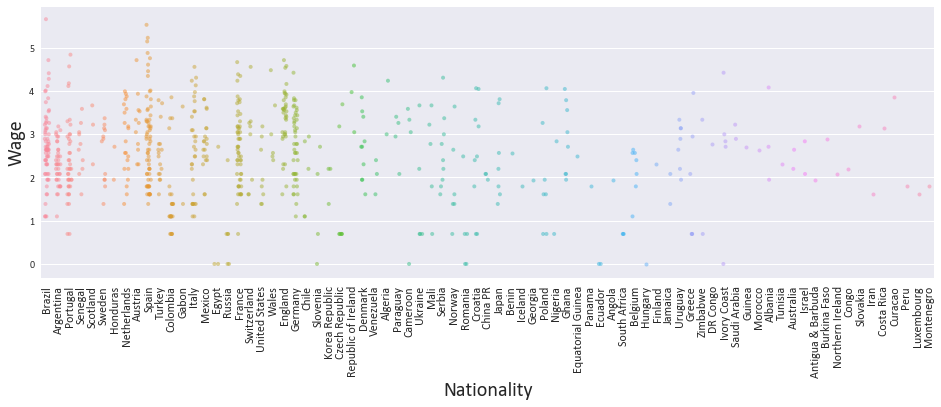

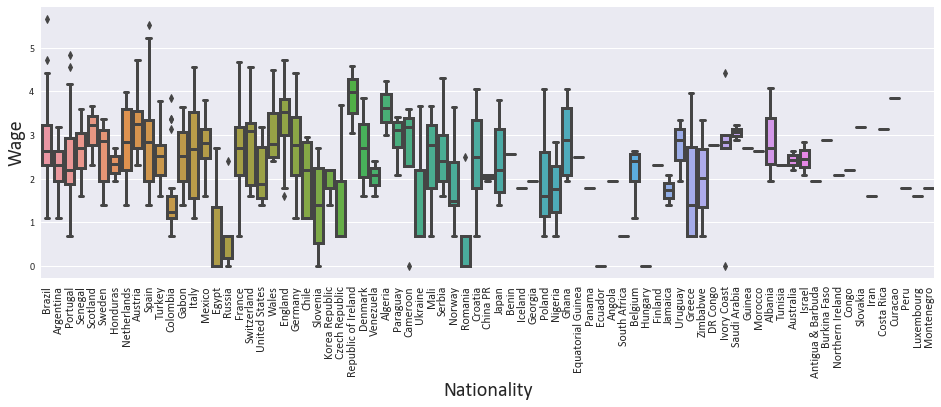

In [9]:
plt.figure(figsize = (16,5))
y = np.log1p(y_train.Wage)
sns.stripplot(x=X_train.Nationality, y=y, linewidth=0, size=4, jitter=0.2, alpha=0.5)
plt.xticks(rotation=90, fontsize=12)
plt.show()

plt.figure(figsize = (16,5))
sns.boxplot(x=X_train.Nationality, y=y)
plt.xticks(rotation=90, fontsize=12)
plt.show()

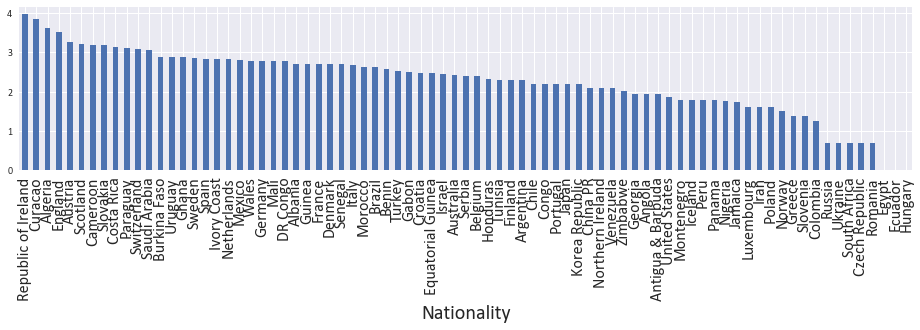

In [10]:
plt.figure(figsize=(16,3))
y = np.log1p(y_train.Wage)
y.groupby(X_train.Nationality).median().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

 중앙값 기준으로 나열해서 국가별로 등급을 매겨보자

대륙별로 묶는 등 다양한 방법이 있겠지만, 합리적인 처리방안이 딱히 떠오르지 않게 때문에 우선 이 변수는 제외하고 진행해보자

### - `Club`
- 너무 다양한 클럽들이 있으므로 이 또한 제외해보자

In [11]:
X_train.Club.value_counts()

Deportivo de La Coruña         5
RB Leipzig                     5
Vitória Guimarães              5
Girona FC                      5
Trabzonspor                    5
                              ..
Tiburones Rojos de Veracruz    1
Kaizer Chiefs                  1
CD Antofagasta                 1
Deportes Tolima                1
Godoy Cruz                     1
Name: Club, Length: 349, dtype: int64

### - `Preferred Foot`: 선호하는 발
### - `Weak Foot`: 반대발 사용 능력

    - Preferred Foot
        - 0,1 로 인코딩
    - Weak Foot
        - 성민석 형꺼 보고 따라하기

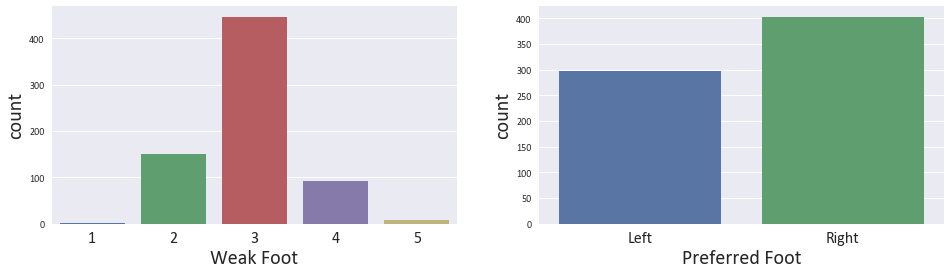

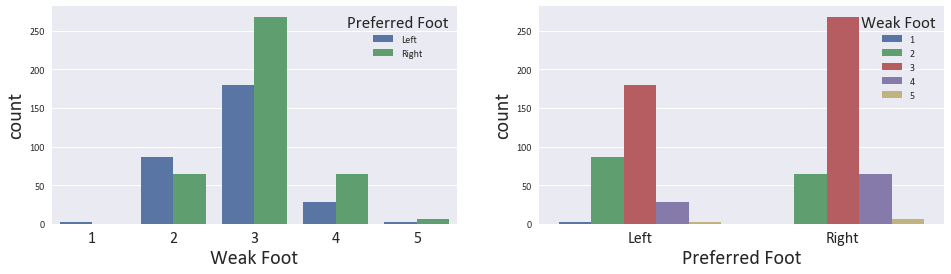

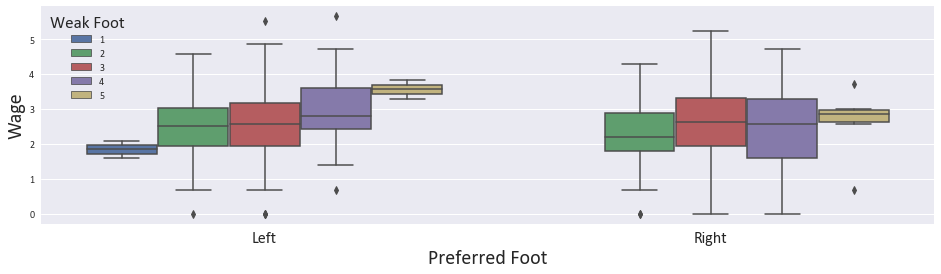

In [12]:
 # Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)
sns.countplot(X_train['Weak Foot'], ax=axes[0])
sns.countplot(X_train['Preferred Foot'], ax=axes[1])

f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)
sns.countplot(X_train['Weak Foot'], hue=X_train['Preferred Foot'], ax=axes[0])
sns.countplot(X_train['Preferred Foot'], hue=X_train['Weak Foot'], ax=axes[1])

plt.figure(figsize = (16,4))
data = X_train['Preferred Foot']
y = np.log1p(y_train.Wage)
sns.boxplot(x = data, y=y , hue = X_train['Weak Foot'], linewidth=1.5)

#plt.figure(figsize = (16,4))
#data = X_train['Weak Foot']
#y = y = np.log1p(y_train.Wage)
#sns.boxplot(x = data, y=y , hue = X_train['Preferred Foot'], linewidth=1.5)

- `Weak Foot`은 이미 numerical value이기 때문에 그대로 두자
- `preferred Foot`은 0, 1로 인코딩 해보자
    - 왼발 선수들은 양발에 능숙할수록 Wage가 올라가는 반면, 오른발 선수들에겐 그런 경향이 덜하다
    - 직접 지정하여 값을 바꾸어도 되고 
    - ***Scikit Learn***에서 지원하는 `Label Encoder`를 사용해도 되고
    - ***Pandas***에서 지원하는 `factorizer`를 사용해도 된다 
    - 두가지 분류(left/right)밖에 없기 때문에 0,1로 바꾸기만 하면 일단 완료

In [13]:
pf_mapping = {'Left':0, 'Right':1}

for df in tnt:
    df['Preferred Foot'] = df['Preferred Foot'].map(pf_mapping)

X_train['Preferred Foot'].head()

432    0
671    0
641    1
805    0
920    0
Name: Preferred Foot, dtype: int64

In [14]:
# Scikit-learn Label Encoder
# label_encoder = preprocessing.LabelEncoder()
# label_encoder.fit(X_train['Preferred Foot'])

# for df in tt_cat :
#    df['Preferred Foot'] = label_encoder.transform(df['Preferred Foot'])

# X_train_cat['Preferred Foot'].head()

### - `International Reputaion`: 국제적 명성

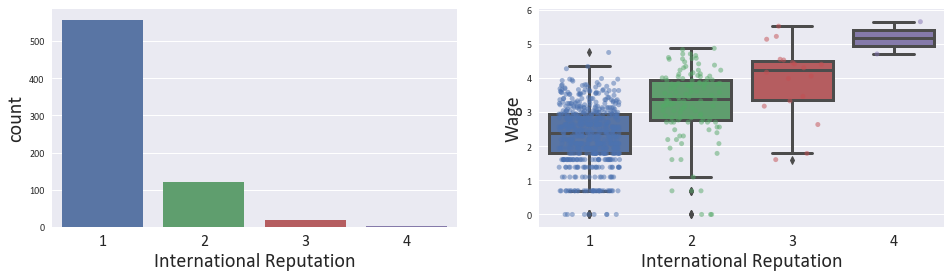

In [15]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['International Reputation']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data,y, ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])

- wage와 관계가 있어보이고, 이미 numerical value이기 때문에 형태는 유지하되, 최소값이 0이 되도록 변환해보자 (연습)

In [16]:
repu_mapping = {1:0, 2:1, 3:2, 4:3, 5:4}

for df in tnt:
    df['International Reputation'] = df['International Reputation'].map(repu_mapping)

X_train['International Reputation'].head()

432    0
671    0
641    0
805    0
920    0
Name: International Reputation, dtype: int64

### - `Skill Moves`: 개인기 능력

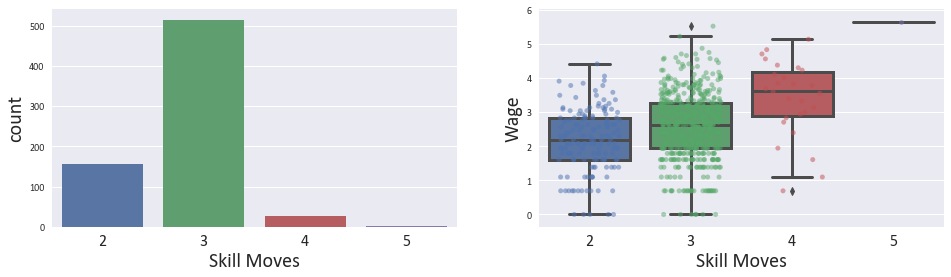

In [17]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Skill Moves']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data,y, ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])

In [18]:
skill_moves_mapping = {1:0, 2:1, 3:2, 4:3, 5:4}

for df in tnt:
    df['Skill Moves'] = df['Skill Moves'].map(skill_moves_mapping)

X_train['Skill Moves'].head()

432    2
671    1
641    2
805    1
920    2
Name: Skill Moves, dtype: int64

### - `Work Rate`: 공격/수비 성향

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

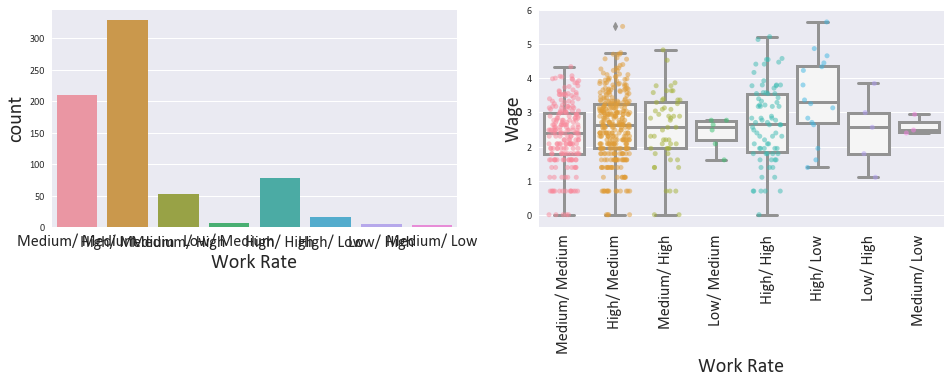

In [19]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Work Rate']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

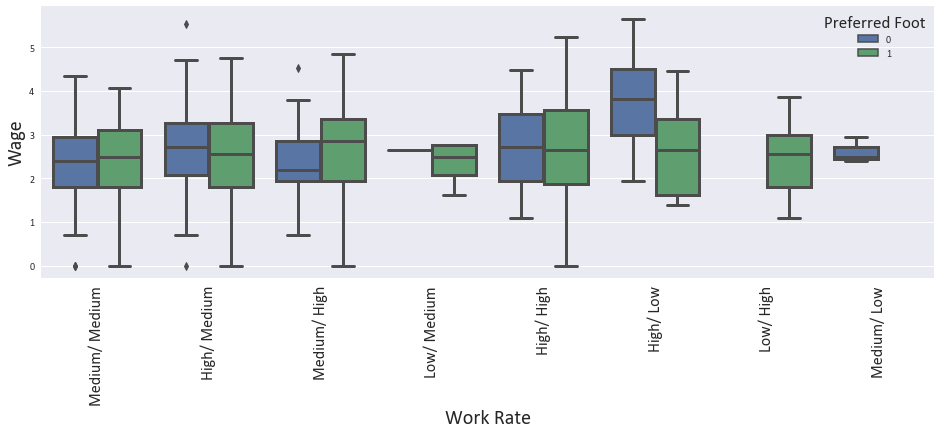

In [20]:
data = X_train['Work Rate']
y = np.log1p(y_train.Wage)
plt.figure(figsize=(16,5))
sns.boxplot(data, y, hue=X_train['Preferred Foot'])
plt.xticks(rotation=90)


- `/ `기호를 기준으로 나누고, 숫자형으로 변환을 해보자

In [21]:
# 이런식으로 한꺼번에 처리를 해보자
X_train['Work Rate'].str.split('/ ')

432    [Medium, Medium]
671      [High, Medium]
641      [High, Medium]
805    [Medium, Medium]
920      [Medium, High]
             ...       
767      [High, Medium]
72         [High, High]
908      [High, Medium]
235    [Medium, Medium]
37     [Medium, Medium]
Name: Work Rate, Length: 700, dtype: object

In [22]:
for df in tnt:
    df[['offense','defense']] = df['Work Rate'].str.split('/ ', n = 2, expand=True)
    
X_train[['offense','defense']].head()

offense defense
432  Medium  Medium
671    High  Medium
641    High  Medium
805  Medium  Medium
920  Medium    High

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

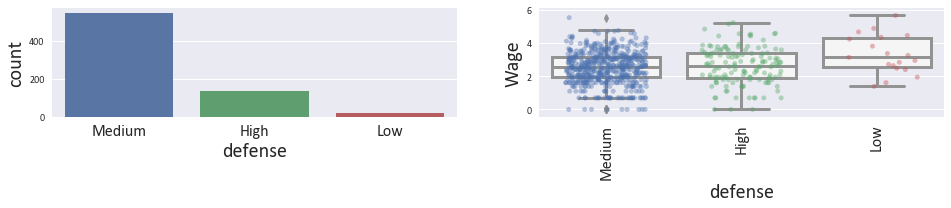

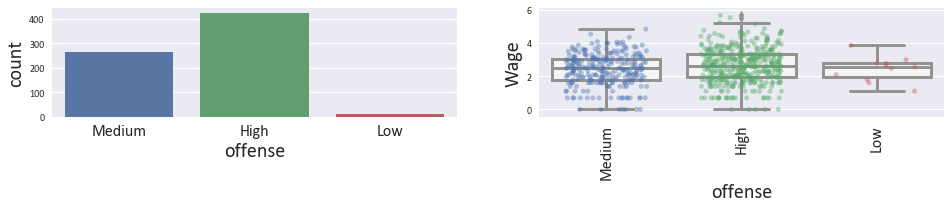

In [23]:
f, axes = plt.subplots(1, 2, figsize=(16, 2), sharex=False)

data = X_train['defense']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.4, ax=axes[1])
plt.xticks(rotation=90)

###################################################
f, axes = plt.subplots(1, 2, figsize=(16, 2), sharex=False)

data = X_train['offense']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.4, ax=axes[1])
plt.xticks(rotation=90)

원핫인코딩을 해줍니다
- 해당 변수가 갖고있는 카테고리의 갯수만큼 차원이 늘어난다는 단점이 있지만 일단 시도해봅시다.

In [24]:
# train
defense = pd.get_dummies(X_train['defense'])
defense.columns = ['def_hi', 'def_low','def_mid']

offense = pd.get_dummies(X_train['offense'])
offense.columns = ['off_hi', 'off_low','off_mid']

X_train = pd.concat([X_train, defense, offense], axis=1)

# test
defense = pd.get_dummies(X_test['defense'])
defense.columns = ['def_hi', 'def_low','def_mid']

offense = pd.get_dummies(X_test['offense'])
offense.columns = ['off_hi', 'off_low','off_mid']

X_test = pd.concat([X_test, defense, offense], axis=1)

In [25]:
X_train.head(2)

Name  Age Nationality  Overall               Club  \
432  Enzo Merques   34      Brazil       72      Internacional   
671   C. Corvalán   29   Argentina       70  Unión de Santa Fe   

     Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
432               0                         0          4            2   
671               0                         0          3            1   

          Work Rate  ... StandingTackle SlidingTackle offense  defense def_hi  \
432  Medium/ Medium  ...             68            69  Medium   Medium      0   
671    High/ Medium  ...             65            66    High   Medium      0   

    def_low  def_mid  off_hi  off_low  off_mid  
432       0        1       0        0        1  
671       0        1       1        0        0  

[2 rows x 55 columns]

원핫 인코딩 된 변수들을 training data set에 합쳐줍니다

In [26]:
tnt[0] = X_train
tnt[1] = X_test

### - `Body Type`: 체형

In [27]:
# <img src="attachment:image.png" width=50%>  ## 마크다운 이미지 사이즈 조절

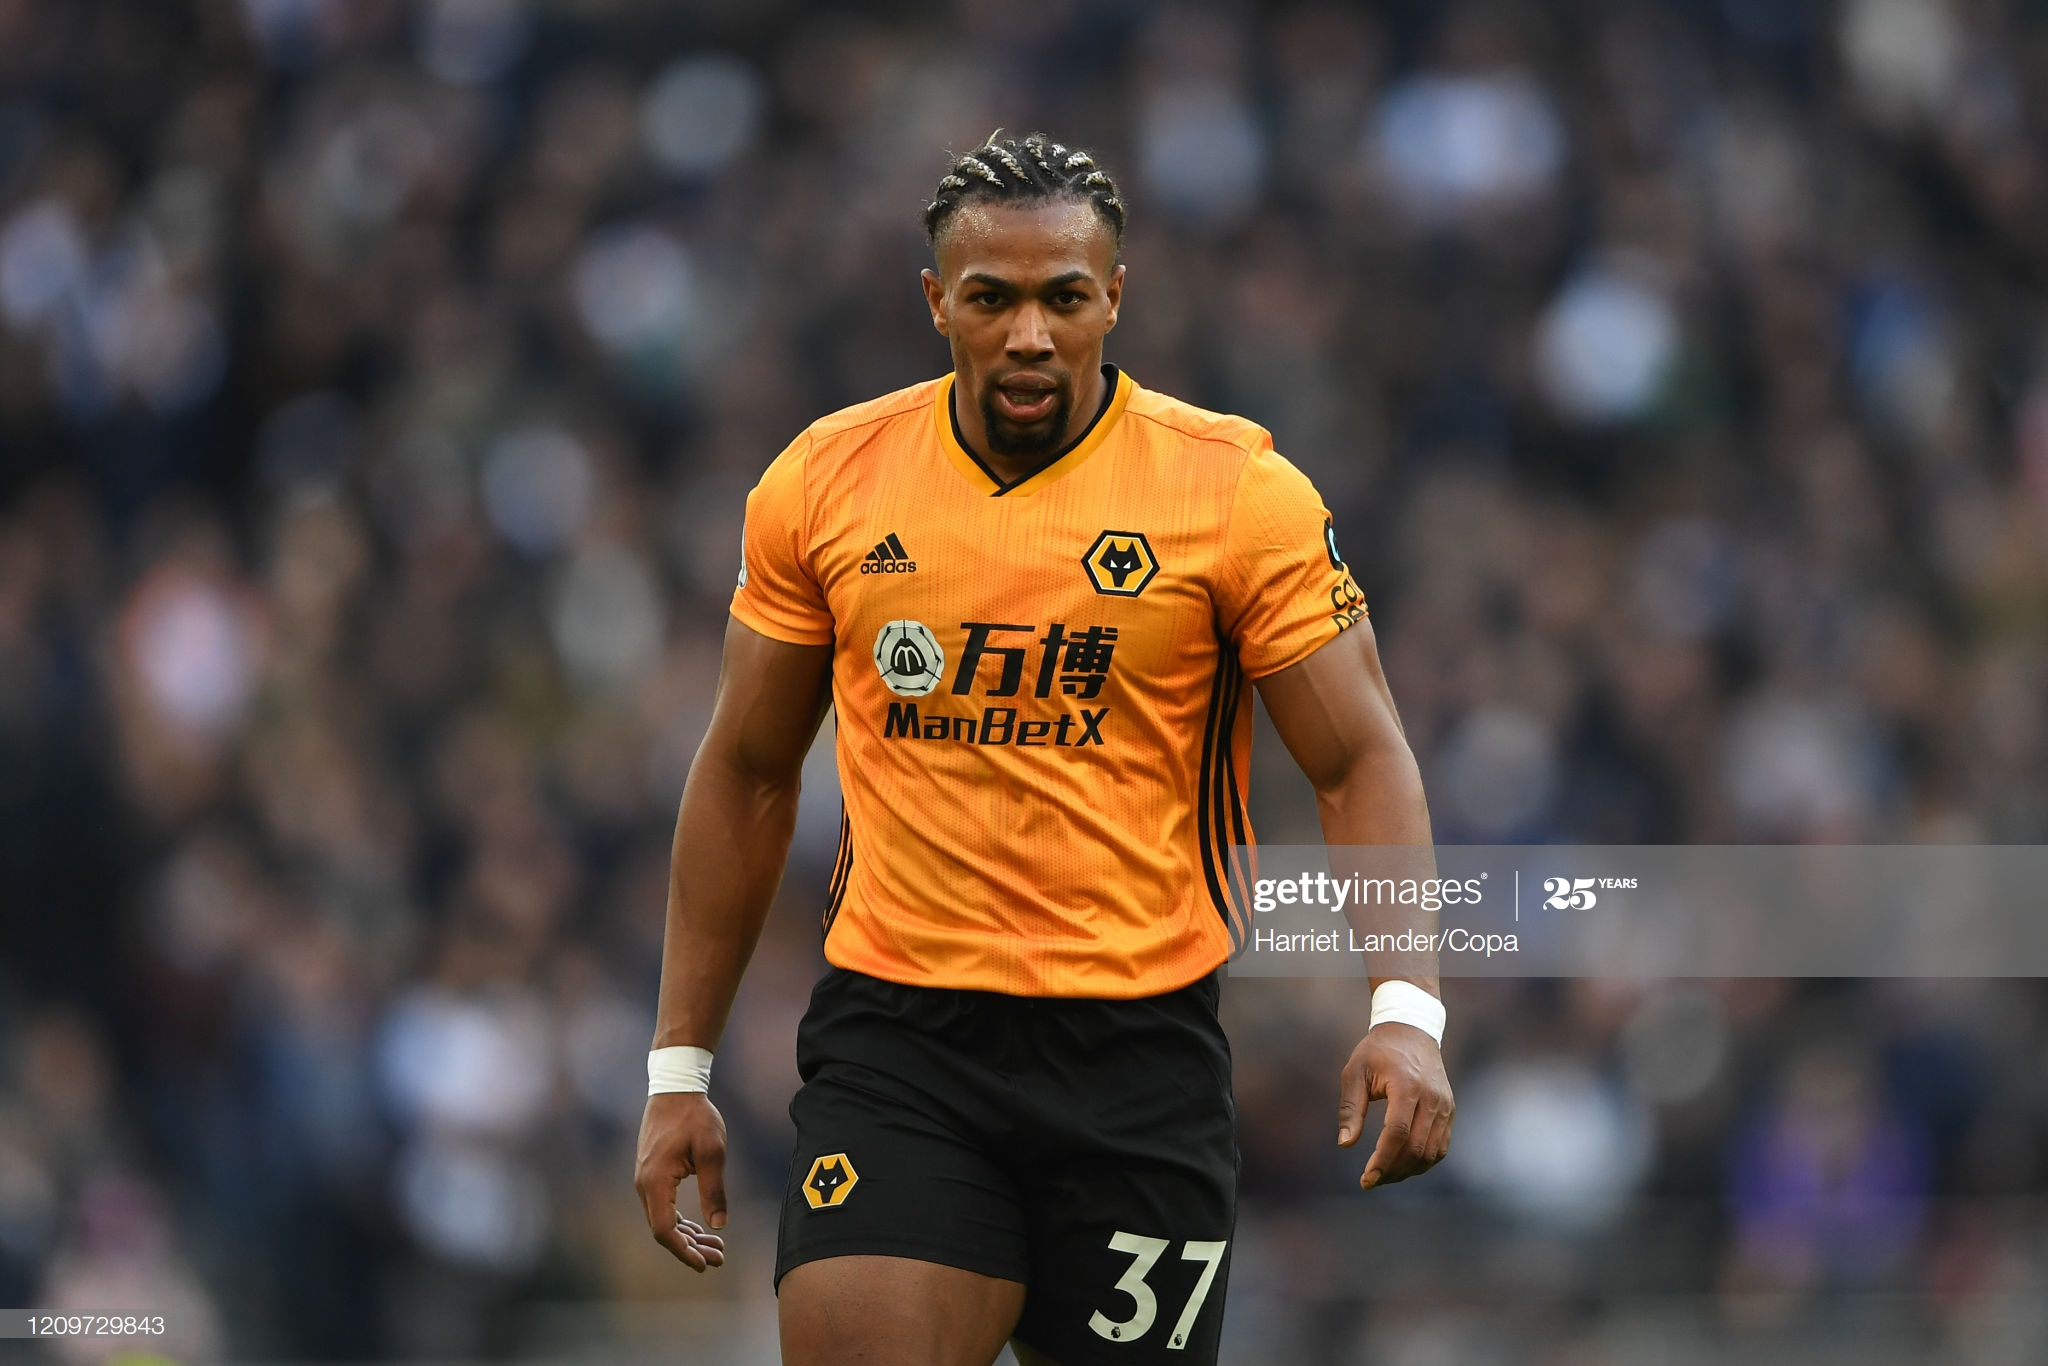

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

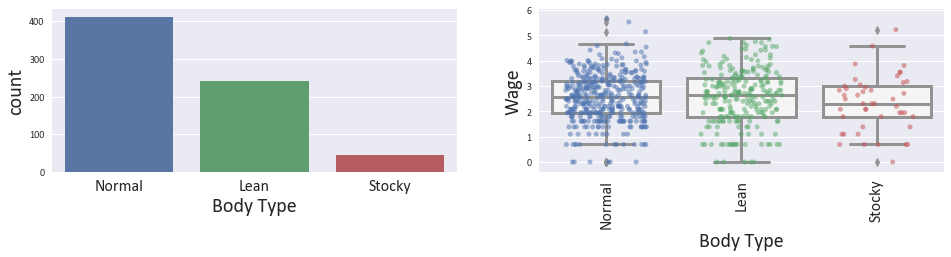

In [28]:
f, axes = plt.subplots(1, 2, figsize=(16, 3), sharex=False)

data = X_train['Body Type']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

다양한 변수들과 함꼐 이리저리 살펴봐야하지만 일단은 원핫인코딩을 해보자

In [29]:
# train
body = pd.get_dummies(X_train['Body Type'])
body.columns = ['body_lean','body_normal','body_stocky']

X_train = pd.concat([X_train, body], axis=1)

# test
body = pd.get_dummies(X_test['Body Type'])
body.columns = ['body_lean','body_normal','body_stocky']

X_test = pd.concat([X_test, body], axis=1)

In [30]:
X_train.head(2)

Name  Age Nationality  Overall               Club  \
432  Enzo Merques   34      Brazil       72      Internacional   
671   C. Corvalán   29   Argentina       70  Unión de Santa Fe   

     Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
432               0                         0          4            2   
671               0                         0          3            1   

          Work Rate  ... defense def_hi def_low  def_mid off_hi off_low  \
432  Medium/ Medium  ...  Medium      0       0        1      0       0   
671    High/ Medium  ...  Medium      0       0        1      1       0   

     off_mid  body_lean  body_normal  body_stocky  
432        1          0            1            0  
671        0          0            1            0  

[2 rows x 58 columns]

원핫 인코딩 된 변수들을 training data set에 합쳐줍니다

In [31]:
tnt[0] = X_train
tnt[1] = X_test

### - `Real Face`

유명한 선수는 게임상에 페이스온이 되어있겠죠,,,

연습하는데 있어서 공정한 변수가 아니라고 판단하여 변수는 실습에서 제외하도록 하겠습니다.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

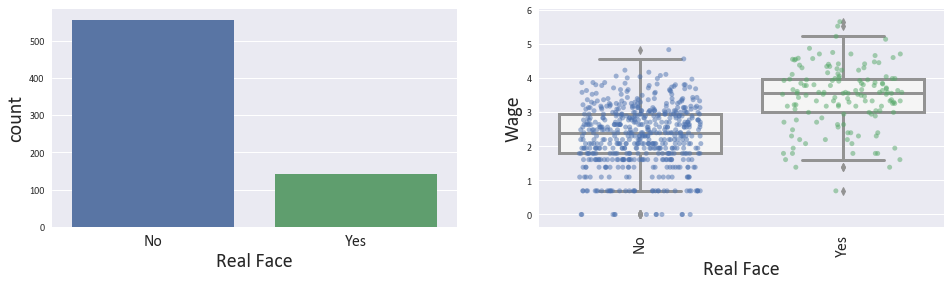

In [32]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Real Face']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

### - `Position`

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

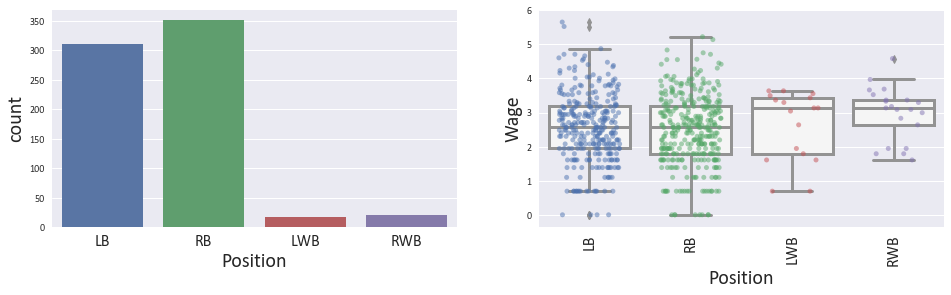

In [33]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Position']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

### - `Jersey Number`: 등번호

도메인 지식을 활용하여 전처리를 해보자.

보통 축구에서 측면수를 대표하는 번호는 2, 3번이다. 그렇다고 꼭 `Wage`가 높지는 않다..

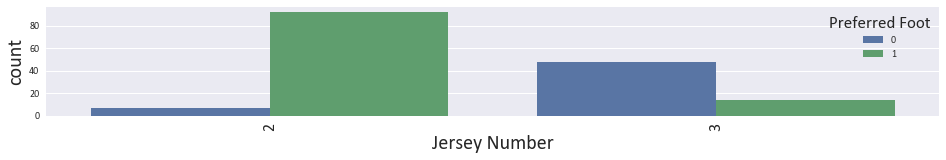

In [34]:
data = pd.concat([y_train['Wage'], X_train['Jersey Number']], axis=1)[X_train['Jersey Number'] < 4]

#f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = pd.concat([y_train['Wage'], X_train['Jersey Number']], axis=1)[X_train['Jersey Number'] < 4]
x = data['Jersey Number']
y = data.Wage

plt.figure(figsize=(16,2))
sns.countplot(x, hue = X_train['Preferred Foot'])
plt.xticks(rotation=90)
plt.show()

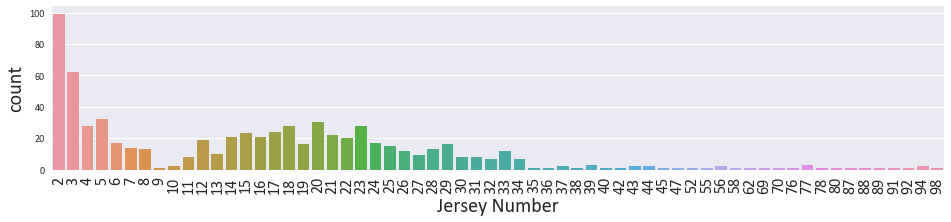

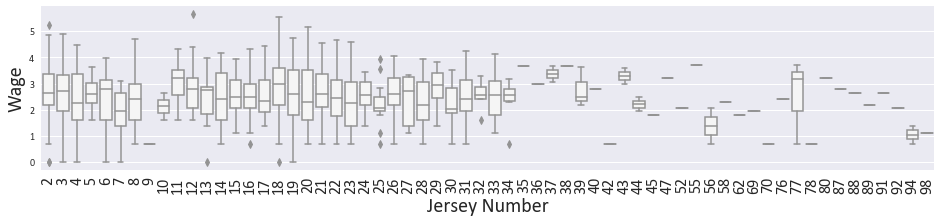

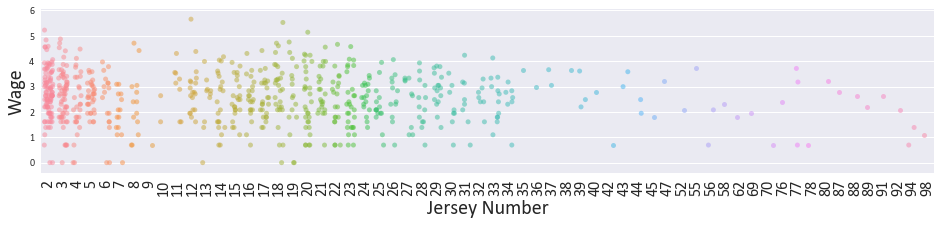

In [35]:
#f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Jersey Number']
y = np.log1p(y_train.Wage)

plt.figure(figsize=(16,3))
sns.countplot(data)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(16,3))
sns.boxplot(data, y ,color='#f5f5f5', linewidth=1.5)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(16,3))
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5)
plt.xticks(rotation=90)
plt.show()

In [36]:
# 등번호별 Wage의 중앙값을 기준으로 정렬해봅시다
df = pd.concat([np.log1p(y_train), X_train], axis=1)
df = df.loc[:,['Wage','Jersey Number']]
df.groupby('Jersey Number').median().sort_values(by='Wage', ascending=False)

Wage
Jersey Number          
55             3.713572
35             3.663562
38             3.663562
37             3.354042
43             3.289626
...                 ...
94             1.039721
9              0.693147
78             0.693147
70             0.693147
42             0.693147

[62 rows x 1 columns]

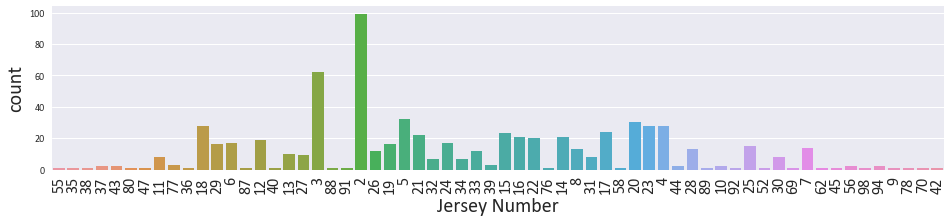

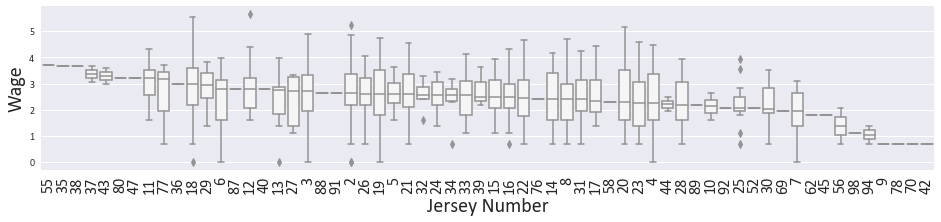

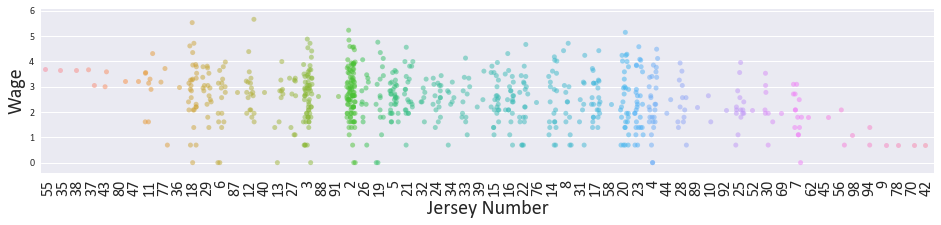

In [37]:
#f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)


data = X_train['Jersey Number']
y = np.log1p(y_train.Wage)

df = pd.concat([np.log1p(y_train), X_train], axis=1)
df = df.loc[:,['Wage','Jersey Number']]
w_order = df.groupby('Jersey Number').median().sort_values(by='Wage', ascending=False)


plt.figure(figsize=(16,3))
sns.countplot(data, order=w_order.index )
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(16,3))
sns.boxplot(data, y ,color='#f5f5f5', linewidth=1.5, order=w_order.index)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(16,3))
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, order=w_order.index)
plt.xticks(rotation=90)
plt.show()

In [38]:
# count가 10 이상인 등번호로 다시 보겠습니다
over10 = pd.DataFrame(df['Jersey Number'].value_counts() >= 10)
over10_list = over10.loc[over10['Jersey Number']==True].index
over10_list

Int64Index([ 2,  3,  5, 20, 18,  4, 23, 17, 15, 21, 14, 16, 22, 12, 24,  6, 29,
            19, 25,  7,  8, 28, 33, 26, 13],
           dtype='int64')

In [39]:
df[df['Jersey Number'].isin(over10_list)]

Wage  Jersey Number
432  2.890372             14
671  2.197225              3
641  1.791759             19
805  2.079442              3
920  2.302585             23
..        ...            ...
905  1.945910              3
767  1.609438             22
72   0.000000              2
908  2.639057             24
37   3.367296              4

[612 rows x 2 columns]

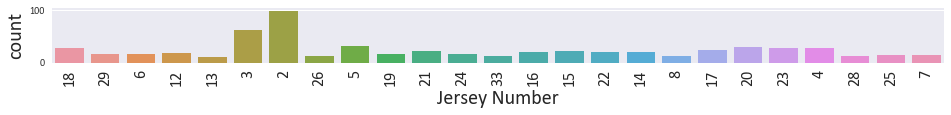

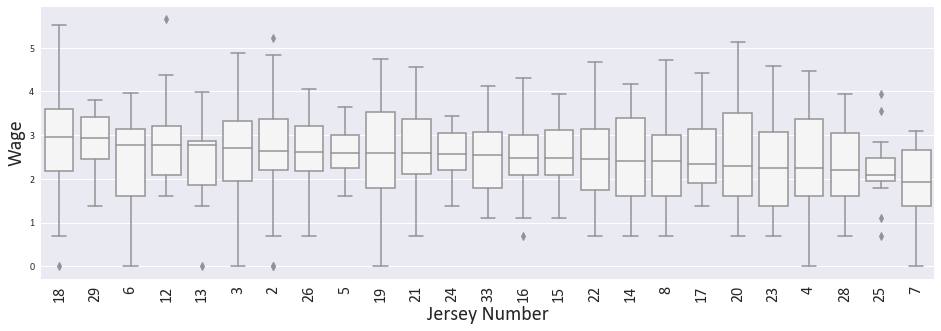

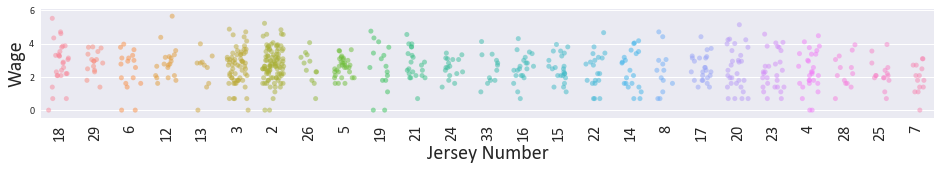

In [40]:
data = X_train['Jersey Number']
y = np.log1p(y_train.Wage)

df = pd.concat([np.log1p(y_train), X_train], axis=1)
df = df.loc[:,['Wage','Jersey Number']]
df = df[df['Jersey Number'].isin(over10_list)]
w_order = df.groupby('Jersey Number').median().sort_values(by='Wage', ascending=False)


plt.figure(figsize=(16,1))
sns.countplot(data, order=w_order.index )
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(16,5))
sns.boxplot(data, y ,color='#f5f5f5', linewidth=1.5, order=w_order.index)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(16,2))
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, order=w_order.index)
plt.xticks(rotation=90)
plt.show()

- [18, 29, 6, 12, 13, 3, 2]
- 2번과 3번을 기준으로 삼아 그 위에 있는 등번호까지 key number로 생각해보겠습니다
- 위 리스트에 속하면 1, 아니면 0을 부여해보겠습니다

In [41]:
# map하고 apply 정리하기
# isin 정리

In [42]:
# 키넘버에 속하면 1, 아니면 0
key_num = [18, 29, 6, 12, 13, 3, 2]

for df in tnt:
    df['num2cat'] = df['Jersey Number'].copy()
    df['num2cat'] = df['num2cat'].apply(lambda x:0 if x not in key_num else x)
    df['num2cat'] = df['num2cat'].apply(lambda x:1 if x in key_num else x)

X_train['num2cat'].head()

432    0
671    1
641    0
805    1
920    0
Name: num2cat, dtype: int64

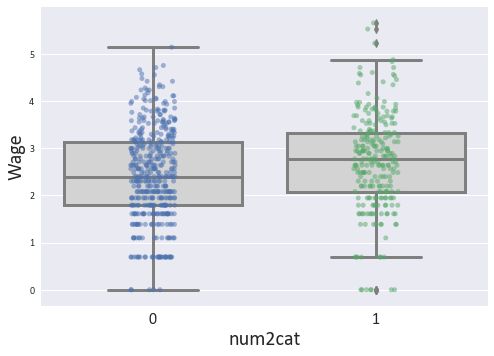

In [43]:
sns.boxplot(X_train.num2cat, np.log1p(y_train.Wage),color = 'lightgray')
sns.stripplot(X_train.num2cat, np.log1p(y_train.Wage), jitter=1, alpha=0.5)

### - `Joined`

In [44]:
X_train['Joined'].head(10)

432     Jan 1, 2018
671    Jul 23, 2018
641     Jul 1, 2016
805     Jul 7, 2015
920    Aug 23, 2017
757     Jan 7, 2016
846    Aug 31, 2015
134    Aug 24, 2016
504     Jul 1, 2014
765     Jun 1, 2014
Name: Joined, dtype: object

날짜 정보가 들어있으므로 연도만 남겨보겠습니다

In [45]:
X_train['Joined'].str.split(',', expand = True)[1]

432     2018
671     2018
641     2016
805     2015
920     2017
       ...  
767     2018
72       NaN
908      NaN
235     2018
37      2017
Name: 1, Length: 700, dtype: object

In [46]:
#pd.tonumeric 정리하기
#결측값 처리
#fillna 정리하기

결측치에 일단 0을 채워넣고, 그림을 그려봅시다

In [47]:
join_year = X_train['Joined'].str.split(',', expand = True)
join_year = join_year[1]
join_year = pd.to_numeric(join_year)
join_year = join_year.fillna(0)
X_train['join_year'] = join_year
X_train['join_year']

432    2018.0
671    2018.0
641    2016.0
805    2015.0
920    2017.0
        ...  
767    2018.0
72        0.0
908       0.0
235    2018.0
37     2017.0
Name: join_year, Length: 700, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

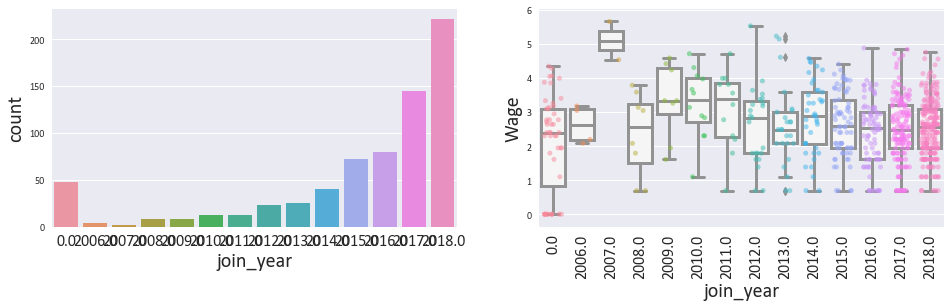

In [48]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['join_year']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

In [49]:
# train과 test에 해당 작업을 해줍니다

for df in tnt:
    join_year = df['Joined'].str.split(',', expand = True)
    join_year = join_year[1]
    join_year = pd.to_numeric(join_year)
    join_year = join_year.fillna(0)
    df['join_year'] = join_year
    df['join_year']
    
X_train['join_year']

432    2018.0
671    2018.0
641    2016.0
805    2015.0
920    2017.0
        ...  
767    2018.0
72        0.0
908       0.0
235    2018.0
37     2017.0
Name: join_year, Length: 700, dtype: float64

null값에 대해서 중앙값으로 처리를 해주겠습니다

In [50]:
# 0에 null값을 다시 채우고 중앙값으로 대체
X_train['join_year'] = X_train['join_year'].apply(lambda x : np.nan if x==0 else x)
X_train['join_year'] = X_train['join_year'].apply(lambda x : X_train['join_year'].median() if np.isnan(x)==1 else x)
X_train['join_year']

432    2018.0
671    2018.0
641    2016.0
805    2015.0
920    2017.0
        ...  
767    2018.0
72     2017.0
908    2017.0
235    2018.0
37     2017.0
Name: join_year, Length: 700, dtype: float64

In [51]:
# train과 test에 해당 작업을 해줍니다

for df in tnt:
    df['join_year'] = df['join_year'].apply(lambda x : np.nan if x==0 else x)
    df['join_year'] = df['join_year'].apply(lambda x : df['join_year'].median() if np.isnan(x)==1 else x)
    
X_train['join_year']

432    2018.0
671    2018.0
641    2016.0
805    2015.0
920    2017.0
        ...  
767    2018.0
72     2017.0
908    2017.0
235    2018.0
37     2017.0
Name: join_year, Length: 700, dtype: float64

In [52]:
# 2018년과의 차이를 구해서 현재 팀에 머무른 햇수를 구해봅니다.
X_train['stay_year'] = 2018 - X_train['join_year']
X_train['stay_year']

432    0.0
671    0.0
641    2.0
805    3.0
920    1.0
      ... 
767    0.0
72     1.0
908    1.0
235    0.0
37     1.0
Name: stay_year, Length: 700, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

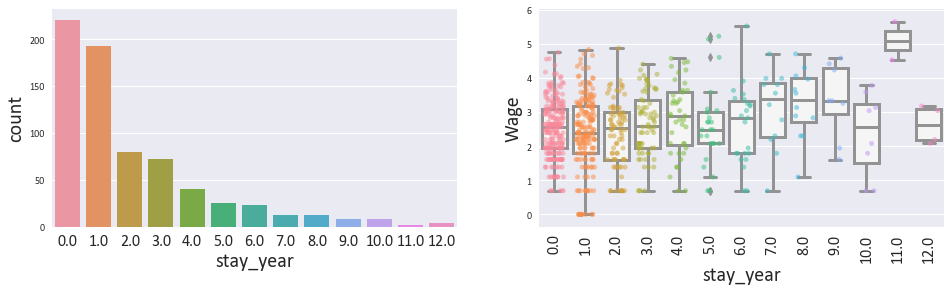

In [53]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['stay_year']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

In [54]:
# train과 test에 해당 작업을 해줍니다
for df in tnt:
    df['stay_year'] = 2018 - df['join_year']
    df['stay_year']
    
X_train['stay_year'].head()

432    0.0
671    0.0
641    2.0
805    3.0
920    1.0
Name: stay_year, dtype: float64

팀에 옮겨왔을 때 선수의 나이를 나타내는 변수를 구해봅시다

아무래도 팀을 옮기면서 계약할 때 Wage에 영향을 미치지 않을까요?

In [55]:
X_train['join_age'] = X_train['Age']-X_train['stay_year']
X_train['join_age']

432    34.0
671    29.0
641    21.0
805    21.0
920    22.0
       ... 
767    30.0
72     28.0
908    19.0
235    36.0
37     23.0
Name: join_age, Length: 700, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text xticklabel objects>)

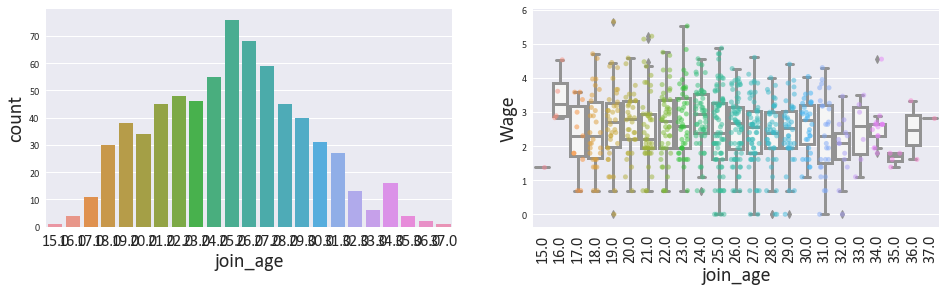

In [56]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['join_age']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

In [57]:
# train과 test에 해당 작업을 해줍니다
for df in tnt:
    df['join_age'] = df['Age'] - df['stay_year']
    df['join_age']
    
X_train['join_age'].head()

432    34.0
671    29.0
641    21.0
805    21.0
920    22.0
Name: join_age, dtype: float64

수치상으로는 별 관련이 없어보입니다

### - `Loaned From`
    - 어느 팀에서 임대왔는지를 나타냄 - 몇명 없으니 제외하자

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

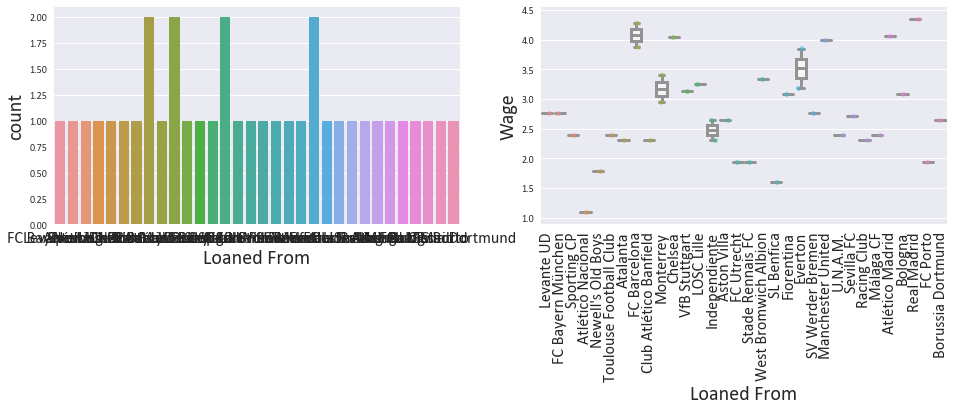

In [58]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Loaned From']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

----------


## Scaling

- 데이터를 모델에 넣기 전에 Scaling을 해봅시다

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 432 to 37
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      700 non-null    object 
 1   Age                       700 non-null    int64  
 2   Nationality               700 non-null    object 
 3   Overall                   700 non-null    int64  
 4   Club                      688 non-null    object 
 5   Preferred Foot            700 non-null    int64  
 6   International Reputation  700 non-null    int64  
 7   Weak Foot                 700 non-null    int64  
 8   Skill Moves               700 non-null    int64  
 9   Work Rate                 700 non-null    object 
 10  Body Type                 700 non-null    object 
 11  Real Face                 700 non-null    object 
 12  Position                  700 non-null    object 
 13  Jersey Number             700 non-null    int64  
 14  Joined   

In [60]:
X_train.columns

Index(['Name', 'Age', 'Nationality', 'Overall', 'Club', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined',
       'Loaned From', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'offense', 'defense',
       'def_hi', 'def_low', 'def_mid', 'off_hi', 'off_low', 'off_mid',
       'body_lean', 'body_normal', 'body_stocky', 'num2cat', 'join_year',
       'stay_year', 'join_age'],
      dtype='object')

In [61]:
# nermical 하지 않은 데이터들을 제외하기

final_variable = ['Age', 'Preferred Foot',
                       'International Reputation', 'Weak Foot', 'Skill Moves', 
                       'Height', 'Weight', 
                       'Crossing', 'Finishing',
                       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
                       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
                       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
                       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
                       'Marking', 'StandingTackle', 'SlidingTackle',
                       'def_hi', 'def_low', 'def_mid', 'off_hi', 'off_low', 'off_mid',
                       'body_lean', 'body_normal', 'body_stocky', 'num2cat',
                       'stay_year', 'join_age']

In [62]:
X_train = X_train.loc[:, final_variable]
X_test  = X_test.loc[:, final_variable]

X_train.head()

Age  Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
432   34               0                         0          4            2   
671   29               0                         0          3            1   
641   23               1                         0          4            2   
805   24               0                         0          3            1   
920   23               0                         0          2            2   

     Height   Weight  Crossing  Finishing  HeadingAccuracy  ...  def_mid  \
432  187.96  76.2048        75         57               68  ...        1   
671  177.80  78.0192        71         35               63  ...        1   
641  175.26  68.9472        73         60               56  ...        1   
805  185.42  69.8544        71         27               68  ...        1   
920  177.80  77.1120        71         33               58  ...        0   

     off_hi  off_low  off_mid  body_lean  body_normal  body_stocky  num2cat  \
432       0        0        1          0            1            0        0   
671       1        0        0          0            1            0        1   
641       1        0        0          1            0            0        0   
805       0        0        1          1            0            0        1   
920       0        0        1          0            1            0        0   

     stay_year  join_age  
432        0.0      34.0  
671        0.0      29.0  
641        2.0      21.0  
805        3.0      21.0  
920        1.0      22.0  

[5 rows x 48 columns]

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

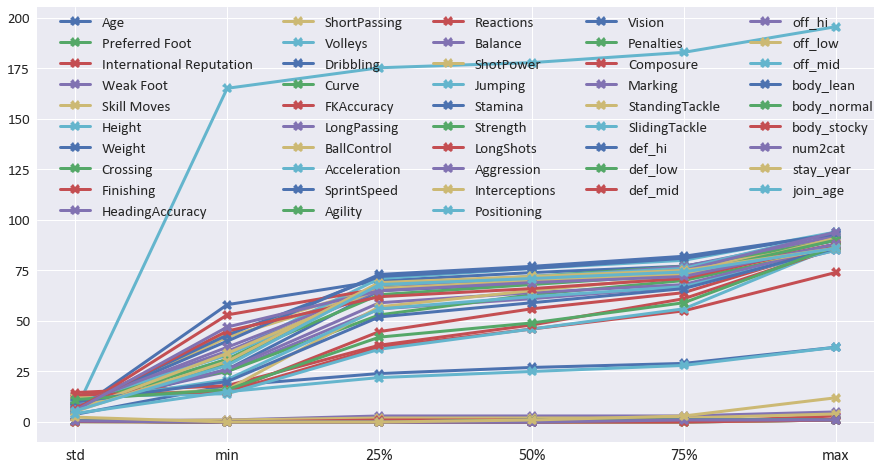

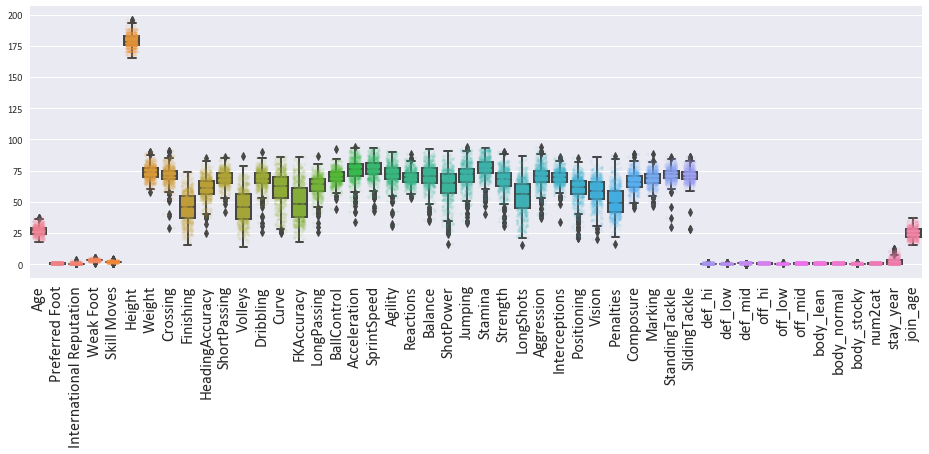

In [64]:
X_train.describe().iloc[2:].plot(figsize=(15,8), marker='X', ms=10)
plt.legend(loc= (0.02,0.5) , fontsize=15, ncol=5, framealpha=0)
plt.yticks(fontsize=15)

plt.figure(figsize = (16,5))
sns.boxplot(data = X_train, linewidth=2)
sns.stripplot(data = X_train, linewidth=0, size=3, jitter=0.3, alpha=0.1)
plt.xticks(rotation=90)
plt.show()

- 신체조건, 능력치와 같은 연속형 변수는 **Standard Scaling**을 해보자
- 범주형변수는 **Min-Max Scaling**을 해보자

In [65]:
X_train.columns

Index(['Age', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'def_hi', 'def_low',
       'def_mid', 'off_hi', 'off_low', 'off_mid', 'body_lean', 'body_normal',
       'body_stocky', 'num2cat', 'stay_year', 'join_age'],
      dtype='object')

In [66]:
continuous_variable = ['Age','Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'join_age'] 

categorical_variable = ['Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves','def_hi', 'def_low',
       'def_mid', 'off_hi', 'off_low', 'off_mid', 'body_lean', 'body_normal',
       'body_stocky', 'num2cat']

In [67]:
# min-max는 out-lier에 민감 / sparse feature에는 효과적일 수 있음
# MaxAbs - sparse data에 사용 권장
# MinMaxScaler   Normalizer       MaxAbsScaler        StandardScaler
# RobustScaler   PowerTransformer QuantileTransformer

# scaling - continuous
scaler = StandardScaler()
X_train_continuous_scaled = scaler.fit_transform(X_train.loc[:, continuous_variable])
X_train_continuous_scaled = pd.DataFrame(X_train_continuous_scaled)
X_train_continuous_scaled.columns = continuous_variable

X_test_continuous_scaled  = scaler.fit_transform(X_test.loc[:, continuous_variable])
X_test_continuous_scaled = pd.DataFrame(X_test_continuous_scaled)
X_test_continuous_scaled.columns = continuous_variable

# scaling - categorical
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_categorical_scaled = scaler.fit_transform(X_train.loc[:, categorical_variable])
X_train_categorical_scaled = pd.DataFrame(X_train_categorical_scaled)
X_train_categorical_scaled.columns = categorical_variable

X_test_categorical_scaled  = scaler.fit_transform(X_test.loc[:, categorical_variable])
X_test_categorical_scaled = pd.DataFrame(X_test_categorical_scaled)
X_test_categorical_scaled.columns = categorical_variable

In [68]:
X_train_scaled = pd.concat([X_train_continuous_scaled, X_train_categorical_scaled], axis=1)
X_test_scaled = pd.concat([X_test_continuous_scaled, X_test_categorical_scaled], axis=1)

In [69]:
X_train_scaled

Age    Height    Weight  Crossing  Finishing  HeadingAccuracy  \
0    1.890241  1.897314  0.504524  0.596244   0.924429         0.824673   
1    0.557477 -0.136560  0.842159 -0.025075  -0.913213         0.217403   
2   -1.041841 -0.645029 -0.846018  0.285585   1.175017        -0.632776   
3   -0.775288  1.388846 -0.677200 -0.025075  -1.581446         0.824673   
4   -1.041841 -0.136560  0.673341 -0.025075  -1.080271        -0.389868   
..        ...       ...       ...       ...        ...              ...   
695  0.824030  0.371908  0.251297 -0.180404   0.590313         0.338857   
696  0.557477 -0.136560 -0.677200  0.285585   1.258546         0.946127   
697 -1.841500 -1.661966  0.082480 -0.180404   0.757371        -2.090224   
698  2.423347  0.880377  1.010977  0.906904   1.759721         1.553397   
699 -0.775288  1.897314  1.770656 -0.491064   0.757371         2.889392   

     ShortPassing   Volleys  Dribbling     Curve  ...  def_hi  def_low  \
0        0.510466  1.609366   0.829636  1.042222  ...    -1.0     -1.0   
1       -1.464705  0.567594  -0.905227 -2.095652  ...    -1.0     -1.0   
2        0.151344  0.247049   0.395921 -0.762055  ...    -1.0     -1.0   
3       -0.028217 -0.233769  -0.905227  0.257754  ...    -1.0     -1.0   
4       -0.926022 -1.676223  -0.182367  0.885329  ...     1.0     -1.0   
..            ...       ...        ...       ...  ...     ...      ...   
695     -0.387339 -1.035132  -0.037795 -1.154289  ...    -1.0     -1.0   
696      1.767393  0.888139   0.540492 -0.918949  ...     1.0     -1.0   
697      0.690027  0.407321   0.395921  0.493094  ...    -1.0     -1.0   
698      0.869588  2.651139   0.251349  0.806882  ...    -1.0     -1.0   
699      1.049149  0.567594  -0.905227 -1.311183  ...    -1.0     -1.0   

     def_mid  off_hi  off_low  off_mid  body_lean  body_normal  body_stocky  \
0        1.0    -1.0     -1.0      1.0       -1.0          1.0         -1.0   
1        1.0     1.0     -1.0     -1.0       -1.0          1.0         -1.0   
2        1.0     1.0     -1.0     -1.0        1.0         -1.0         -1.0   
3        1.0    -1.0     -1.0      1.0        1.0         -1.0         -1.0   
4       -1.0    -1.0     -1.0      1.0       -1.0          1.0         -1.0   
..       ...     ...      ...      ...        ...          ...          ...   
695      1.0     1.0     -1.0     -1.0        1.0         -1.0         -1.0   
696     -1.0     1.0     -1.0     -1.0        1.0         -1.0         -1.0   
697      1.0     1.0     -1.0     -1.0       -1.0          1.0         -1.0   
698      1.0    -1.0     -1.0      1.0       -1.0          1.0         -1.0   
699      1.0    -1.0     -1.0      1.0       -1.0          1.0         -1.0   

     num2cat  
0       -1.0  
1        1.0  
2       -1.0  
3        1.0  
4       -1.0  
..       ...  
695     -1.0  
696      1.0  
697     -1.0  
698     -1.0  
699     -1.0  

[700 rows x 47 columns]

In [70]:
X_test_scaled

Age    Height    Weight  Crossing  Finishing  HeadingAccuracy  \
0    1.894735 -0.212033  0.314481 -1.363912  -0.609639        -0.317398   
1    1.354408  1.766945  1.110675  1.204780  -0.099913         1.278975   
2   -1.887554  0.777456  0.933743 -0.155115  -2.223772         0.787784   
3    0.814081 -2.191012 -2.604899  0.147084   2.448718        -0.440196   
4    0.273754 -0.706778 -0.658646 -1.061713   2.023946        -1.054186   
..        ...       ...       ...       ...        ...              ...   
296  0.814081 -0.706778 -0.216316 -0.155115  -0.439731        -0.808590   
297  0.543917  0.777456  0.933743  1.053681   0.749631        -0.808590   
298 -0.536737  0.777456  2.260734  0.902581   1.089448         1.524571   
299  0.543917 -0.212033  1.110675 -0.457315   1.429265         0.296592   
300  0.273754 -1.201523 -0.658646  0.147084   1.004494        -1.668176   

     ShortPassing   Volleys  Dribbling     Curve  ...  def_hi  def_low  \
0       -0.051978  0.174471  -1.957218 -1.064795  ...    -1.0     -1.0   
1        0.506789 -0.370137  -0.508448  0.927889  ...     1.0     -1.0   
2       -0.051978 -1.537154  -2.747456 -1.463331  ...    -1.0     -1.0   
3       -2.473302  1.886095  -2.352337 -1.144502  ...    -1.0     -1.0   
4       -0.238234  1.886095   0.413497  0.609059  ...    -1.0     -1.0   
..            ...       ...        ...       ...  ...     ...      ...   
296     -0.424490  0.719079   0.150084 -0.347429  ...     1.0     -1.0   
297      0.320533  0.407874   0.545203  0.768474  ...    -1.0     -1.0   
298      1.251811  0.174471   0.676909 -1.383624  ...     1.0     -1.0   
299     -0.797001  0.952482   0.281790  0.529352  ...    -1.0     -1.0   
300     -0.238234  0.952482   0.545203 -0.108307  ...    -1.0     -1.0   

     def_mid  off_hi  off_low  off_mid  body_lean  body_normal  body_stocky  \
0        1.0    -1.0      1.0     -1.0       -1.0         -1.0          1.0   
1       -1.0     1.0     -1.0     -1.0       -1.0          1.0         -1.0   
2        1.0    -1.0     -1.0      1.0       -1.0          1.0         -1.0   
3        1.0    -1.0      1.0     -1.0        1.0         -1.0         -1.0   
4        1.0     1.0     -1.0     -1.0       -1.0          1.0         -1.0   
..       ...     ...      ...      ...        ...          ...          ...   
296     -1.0     1.0     -1.0     -1.0        1.0         -1.0         -1.0   
297      1.0    -1.0     -1.0      1.0       -1.0          1.0         -1.0   
298     -1.0    -1.0     -1.0      1.0       -1.0         -1.0          1.0   
299      1.0     1.0     -1.0     -1.0       -1.0          1.0         -1.0   
300      1.0     1.0     -1.0     -1.0        1.0         -1.0         -1.0   

     num2cat  
0       -1.0  
1       -1.0  
2       -1.0  
3       -1.0  
4       -1.0  
..       ...  
296      1.0  
297     -1.0  
298     -1.0  
299     -1.0  
300      1.0  

[301 rows x 47 columns]

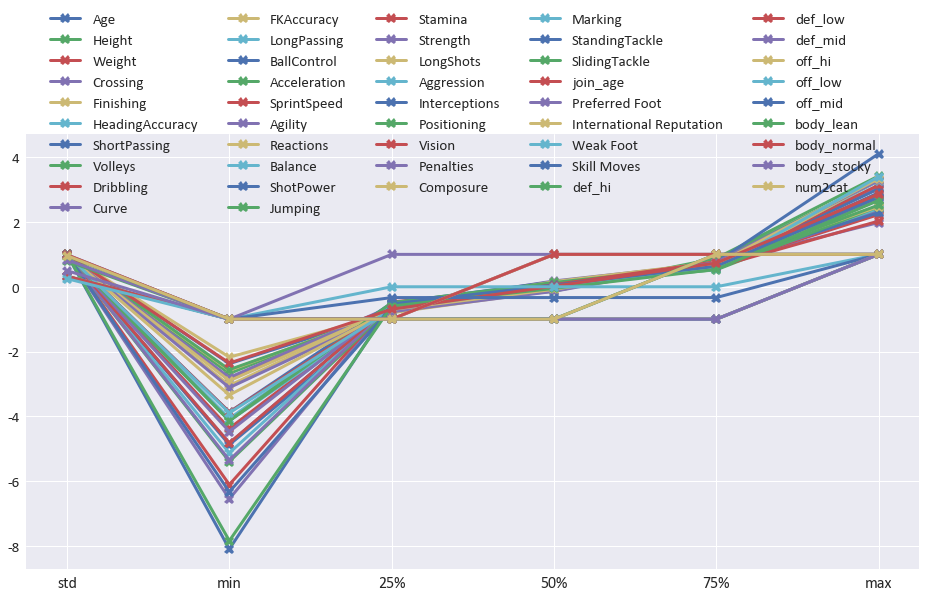

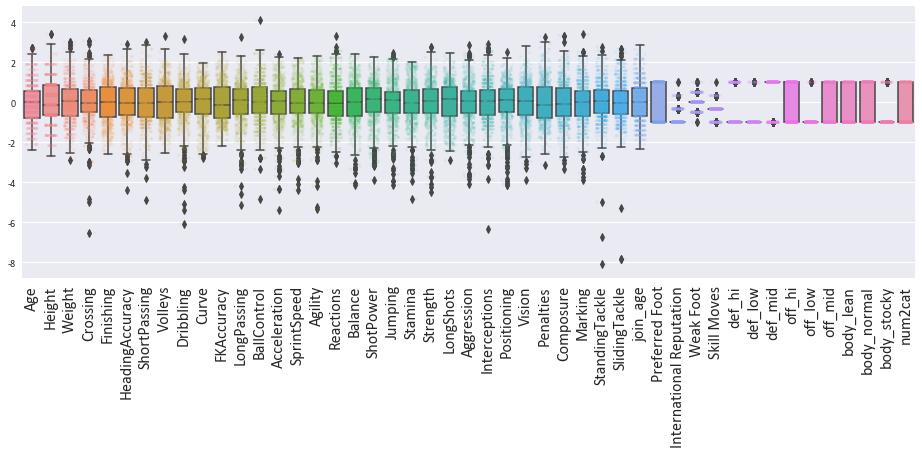

In [71]:
X_train_scaled.describe().iloc[2:].plot(figsize=(16,8), marker='X', ms=10)
plt.legend(loc= (0.02,0.8) , fontsize=15, ncol=5, framealpha=0)
plt.yticks(fontsize=15)
plt.show()

plt.figure(figsize = (16,5))
data = X_train_scaled
sns.boxplot(data = data, linewidth=1.5)
sns.stripplot(data = data, linewidth=0, size=3, jitter=0.3, alpha=0.1)
plt.xticks(rotation=90)
plt.show()

- scaling을 실행하면 index가 reset되기 때문에 y(target)값도 reset_index를 해줍시다

In [72]:
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [73]:
X_train_scaled = pd.concat([y_train, X_train_continuous_scaled, X_train_categorical_scaled], axis=1)
X_test_scaled = pd.concat([y_test, X_test_continuous_scaled, X_test_categorical_scaled], axis=1)

In [74]:
X_train_scaled

Wage       Age    Height    Weight  Crossing  Finishing  HeadingAccuracy  \
0      17  1.890241  1.897314  0.504524  0.596244   0.924429         0.824673   
1       8  0.557477 -0.136560  0.842159 -0.025075  -0.913213         0.217403   
2       5 -1.041841 -0.645029 -0.846018  0.285585   1.175017        -0.632776   
3       7 -0.775288  1.388846 -0.677200 -0.025075  -1.581446         0.824673   
4       9 -1.041841 -0.136560  0.673341 -0.025075  -1.080271        -0.389868   
..    ...       ...       ...       ...       ...        ...              ...   
695     4  0.824030  0.371908  0.251297 -0.180404   0.590313         0.338857   
696     0  0.557477 -0.136560 -0.677200  0.285585   1.258546         0.946127   
697    13 -1.841500 -1.661966  0.082480 -0.180404   0.757371        -2.090224   
698     4  2.423347  0.880377  1.010977  0.906904   1.759721         1.553397   
699    28 -0.775288  1.897314  1.770656 -0.491064   0.757371         2.889392   

     ShortPassing   Volleys  Dribbling  ...  def_hi  def_low  def_mid  off_hi  \
0        0.510466  1.609366   0.829636  ...    -1.0     -1.0      1.0    -1.0   
1       -1.464705  0.567594  -0.905227  ...    -1.0     -1.0      1.0     1.0   
2        0.151344  0.247049   0.395921  ...    -1.0     -1.0      1.0     1.0   
3       -0.028217 -0.233769  -0.905227  ...    -1.0     -1.0      1.0    -1.0   
4       -0.926022 -1.676223  -0.182367  ...     1.0     -1.0     -1.0    -1.0   
..            ...       ...        ...  ...     ...      ...      ...     ...   
695     -0.387339 -1.035132  -0.037795  ...    -1.0     -1.0      1.0     1.0   
696      1.767393  0.888139   0.540492  ...     1.0     -1.0     -1.0     1.0   
697      0.690027  0.407321   0.395921  ...    -1.0     -1.0      1.0     1.0   
698      0.869588  2.651139   0.251349  ...    -1.0     -1.0      1.0    -1.0   
699      1.049149  0.567594  -0.905227  ...    -1.0     -1.0      1.0    -1.0   

     off_low  off_mid  body_lean  body_normal  body_stocky  num2cat  
0       -1.0      1.0       -1.0          1.0         -1.0     -1.0  
1       -1.0     -1.0       -1.0          1.0         -1.0      1.0  
2       -1.0     -1.0        1.0         -1.0         -1.0     -1.0  
3       -1.0      1.0        1.0         -1.0         -1.0      1.0  
4       -1.0      1.0       -1.0          1.0         -1.0     -1.0  
..       ...      ...        ...          ...          ...      ...  
695     -1.0     -1.0        1.0         -1.0         -1.0     -1.0  
696     -1.0     -1.0        1.0         -1.0         -1.0      1.0  
697     -1.0     -1.0       -1.0          1.0         -1.0     -1.0  
698     -1.0      1.0       -1.0          1.0         -1.0     -1.0  
699     -1.0      1.0       -1.0          1.0         -1.0     -1.0  

[700 rows x 48 columns]

- 저장하기

In [76]:
X_train_scaled.to_csv('train_prep.csv', index=False)
X_test_scaled.to_csv('test_prep.csv', index=False)